## EXPERIMENT 1.2: AdaFace

In [1]:
## Load libraries

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import sys
sns.set(style="white")
%matplotlib inline
sys.path.append('../../utils')
from Model_utils.Model_funcs import *
from Result_metric_utils.result_metrics import *
from Data_proc_utils.Data_proc_funcs import *
from DET_utils.DET_plots import *
from DET_utils.DET import *
from Plotting_stats_utils.plotting_threshold import *
from Plotting_stats_utils.stats_tables import *

from IPython import embed


# Load data

In [2]:
feature_list_children = '../../data/data_full/feature_vectors/adaface_feature_vectors/similarity_scores_children_full_baseline1.pt'


image_names_c, ids_c, num_ids_c, norm_feats_c = load_adaface_vectors(feature_list_children)
image_names_a, ids_a, num_ids_a, norm_feats_a = image_names_c, ids_c, num_ids_c, norm_feats_c
# ids_a = ["_".join(x.split("_")[1:]) for x in ids_a]


# Similarity matrices from adaface - all
sim_mat_c = np.dot(norm_feats_c, norm_feats_c.T)
sim_mat_a = np.dot(norm_feats_a, norm_feats_a.T)


# Dataframes with info, removes names not in magface results
children_all = pd.read_csv('../../data/image_info_csvs/final_filtered_canonical_df_BIBLE.csv')
children_all = children_all[children_all.image_name.isin(image_names_c)]

adults_all_org = pd.read_csv('../../data/image_info_csvs/final_filtered_children_df_BIBEL.csv')
adults_all = adults_all_org[adults_all_org.image_name.isin(image_names_a)]

# Finding the threshold

In [3]:
random_states = [4,5,6]
percentiles = [70,72,74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98]

df_all_threshold_x = compute_metrics_ex_1_2(random_states, percentiles, children_all, adults_all, image_names_c, image_names_a, sim_mat_c, sim_mat_a, num_ids_c, num_ids_a, ids_c, ids_a, balance_child_data, balance_adults_data_enrolled, compute_fnir, compute_fpir, GARBE)


FPD result:  0.0
FND result:  0.5
GARBE result, GARBE close to 1 means more unfair:  0.375
Done for random_state: 4, percentile: 70
FPD result:  0.0
FND result:  0.5
GARBE result, GARBE close to 1 means more unfair:  0.375
Done for random_state: 4, percentile: 72
FPD result:  0.0
FND result:  0.5
GARBE result, GARBE close to 1 means more unfair:  0.375
Done for random_state: 4, percentile: 74
FPD result:  0.0
FND result:  0.5
GARBE result, GARBE close to 1 means more unfair:  0.375
Done for random_state: 4, percentile: 76
FPD result:  0.0
FND result:  0.45863673898355983
GARBE result, GARBE close to 1 means more unfair:  0.34397755423766985
Done for random_state: 4, percentile: 78
FPD result:  0.0
FND result:  0.4280144363063306
GARBE result, GARBE close to 1 means more unfair:  0.32101082722974794
Done for random_state: 4, percentile: 80
FPD result:  0.0
FND result:  0.38378362345683076
GARBE result, GARBE close to 1 means more unfair:  0.28783771759262305
Done for random_state: 4, pe

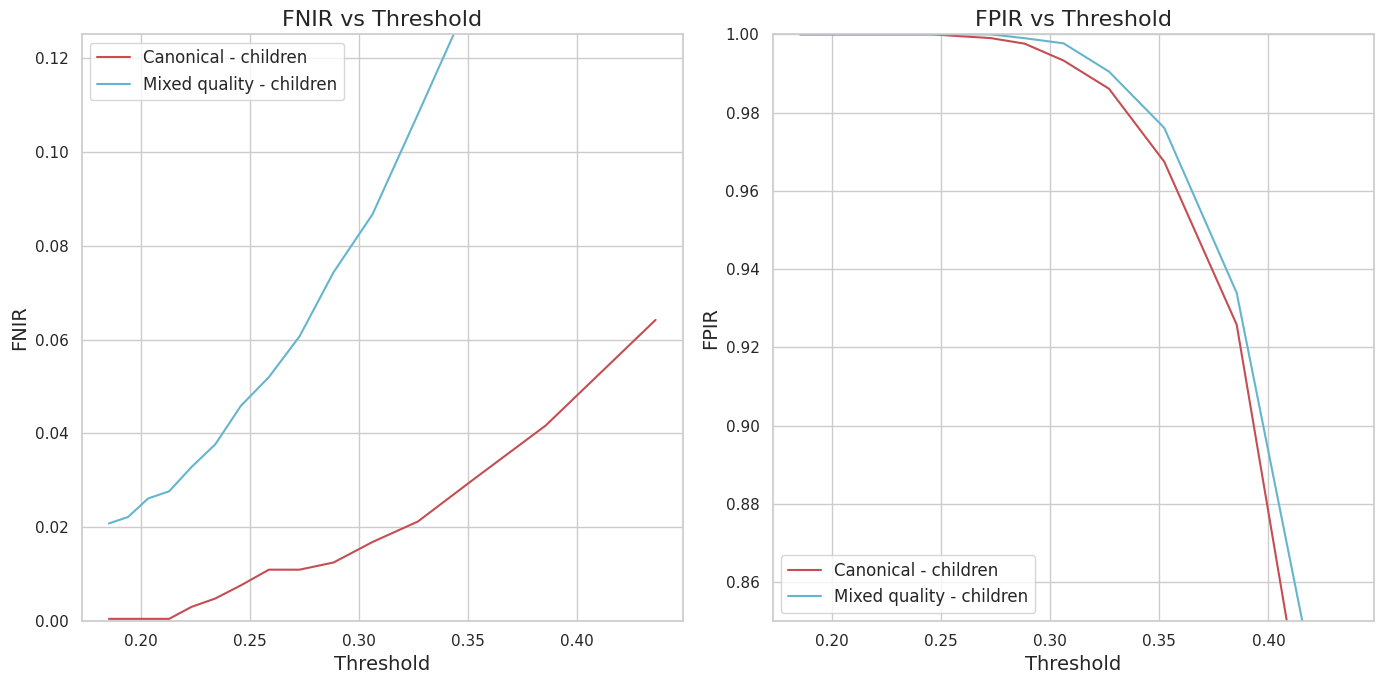

In [4]:
plot_threshold_metrics_ex_1_2(df_all_threshold_x)

# Stats - 10 experiments 

In [9]:
random_states = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

df_all_results, sim_mat_dict_all_magface_ex1_2 = evaluate_metrics_ex_1_2(
    random_states, children_all, adults_all, image_names_c, image_names_a,
    sim_mat_c, sim_mat_a, num_ids_c, num_ids_a, ids_c, ids_a, balance_child_data,
    balance_adults_data_enrolled, compute_fnir, compute_fpir, GARBE, remove_ones, 0.26
)

FPD result:  0.0
FND result:  0.3381055218378821
GARBE result, GARBE close to 1 means more unfair:  0.2535791413784116
done
FPD result:  0.0
FND result:  0.33564543642230305
GARBE result, GARBE close to 1 means more unfair:  0.25173407731672726
done
FPD result:  0.0
FND result:  0.2885386819484241
GARBE result, GARBE close to 1 means more unfair:  0.21640401146131805
done
FPD result:  0.0
FND result:  0.3643775767645068
GARBE result, GARBE close to 1 means more unfair:  0.27328318257338013
done
FPD result:  0.0
FND result:  0.33385955362003267
GARBE result, GARBE close to 1 means more unfair:  0.2503946652150245
done
FPD result:  0.011275766356224355
FND result:  0.2823829055305636
GARBE result, GARBE close to 1 means more unfair:  0.21460612073697882
done
FPD result:  0.0
FND result:  0.32159243168622353
GARBE result, GARBE close to 1 means more unfair:  0.24119432376466765
done
FPD result:  0.0
FND result:  0.35249753099293957
GARBE result, GARBE close to 1 means more unfair:  0.2643

In [10]:
df_all_results.applymap(lambda x: f"{x:.3f}")

/tmp/ipykernel_20793/2398388374.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_all_results.applymap(lambda x: f"{x:.3f}")


,Iteration,FNIR_c,FNIR_a,FPIR_c,FPIR_a,FPD,FND,GARBE,Threshold
0,1.000,0.011,0.057,1.000,1.000,0.000,0.338,0.254,0.260
1,2.000,0.009,0.044,1.000,1.000,0.000,0.336,0.252,0.260
2,3.000,0.012,0.043,1.000,1.000,0.000,0.289,0.216,0.260
3,4.000,0.009,0.055,1.000,1.000,0.000,0.364,0.273,0.260
4,5.000,0.011,0.053,1.000,1.000,0.000,0.334,0.250,0.260
5,6.000,0.014,0.050,0.999,1.000,0.011,0.282,0.215,0.260
6,7.000,0.009,0.043,1.000,1.000,0.000,0.322,0.241,0.260
7,8.000,0.009,0.050,1.000,1.000,0.000,0.352,0.264,0.260
8,9.000,0.012,0.045,1.000,1.000,0.000,0.292,0.219,0.260
9,10.000,0.007,0.049,1.000,1.000,0.000,0.376,0.282,0.260


In [11]:
df_all_results.describe().applymap(lambda x: f"{x:.3f}")

/tmp/ipykernel_20793/1449581749.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_all_results.describe().applymap(lambda x: f"{x:.3f}")


,Iteration,FNIR_c,FNIR_a,FPIR_c,FPIR_a,FPD,FND,GARBE,Threshold
count,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000
mean,5.500,0.010,0.049,1.000,1.000,0.001,0.328,0.247,0.260
std,3.028,0.002,0.005,0.000,0.000,0.004,0.032,0.024,0.000
min,1.000,0.007,0.043,0.999,1.000,0.000,0.282,0.215,0.260
25%,3.250,0.009,0.044,1.000,1.000,0.000,0.299,0.224,0.260
50%,5.500,0.010,0.049,1.000,1.000,0.000,0.335,0.251,0.260
75%,7.750,0.011,0.052,1.000,1.000,0.000,0.349,0.262,0.260
max,10.000,0.014,0.057,1.000,1.000,0.011,0.376,0.282,0.260


# Gemmer simscores

In [12]:
df_all_results.to_csv('results_10_experiment_1_2_adaface.csv')

In [13]:
# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10
# List to hold all the arrays
sim_mat_c_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_c_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_2:
        sim_mat_c_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_2[key])

# Concatenate all arrays into one big array
sim_mat_c_enrolled_iterations_all = np.concatenate(sim_mat_c_enrolled_iterations)
sim_mat_c_enrolled_iterations_all = pd.DataFrame(sim_mat_c_enrolled_iterations_all)
sim_mat_c_enrolled_iterations_all.to_csv('sim_mat_c_enrolled_iterations_all_ada_1_2.csv', index=False)
# Print the big array
print(len(sim_mat_c_enrolled_iterations_all))



# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10

# List to hold all the arrays
sim_mat_a_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_a_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_2:
        sim_mat_a_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_2[key])

# Concatenate all arrays into one big array
sim_mat_a_enrolled_iterations_all = np.concatenate(sim_mat_a_enrolled_iterations)
sim_mat_a_enrolled_iterations_all = pd.DataFrame(sim_mat_a_enrolled_iterations_all)
sim_mat_a_enrolled_iterations_all.to_csv('sim_mat_a_enrolled_iterations_all_ada_1_2.csv', index=False)


# Print the big array
print(len(sim_mat_a_enrolled_iterations_all))

# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10

# List to hold all the arrays
sim_mat_c_non_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_c_non_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_2:
        sim_mat_c_non_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_2[key])

sim_mat_c_non_enrolled_iterations_all = np.concatenate(sim_mat_c_non_enrolled_iterations)
sim_mat_c_non_enrolled_iterations_all = pd.DataFrame(sim_mat_c_non_enrolled_iterations_all)
sim_mat_c_non_enrolled_iterations_all.to_csv('sim_mat_c_non_enrolled_iterations_all_ada_1_2.csv', index=False)
# Print the big array
print(len(sim_mat_c_non_enrolled_iterations_all))


# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10

# List to hold all the arrays
sim_mat_a_non_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_a_non_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_2:
        sim_mat_a_non_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_2[key])

sim_mat_a_non_enrolled_iterations_all = np.concatenate(sim_mat_a_non_enrolled_iterations)
sim_mat_a_non_enrolled_iterations_all = pd.DataFrame(sim_mat_a_non_enrolled_iterations_all)
sim_mat_a_non_enrolled_iterations_all.to_csv('sim_mat_a_non_enrolled_iterations_all_ada_1_2.csv', index=False)

# Print the big array
print(len(sim_mat_a_non_enrolled_iterations_all))


101316
141482
14218887
32751054


# Load sim scores

In [2]:

# Loading pre-saved stuff
sim_mat_c_enrolled_iterations_all = (pd.read_csv('sim_mat_c_enrolled_iterations_all_ada_1_2.csv')).values.flatten()
sim_mat_a_enrolled_iterations_all = (pd.read_csv('sim_mat_a_enrolled_iterations_all_ada_1_2.csv')).values.flatten()
sim_mat_c_non_enrolled_iterations_all = (pd.read_csv('sim_mat_c_non_enrolled_iterations_all_ada_1_2.csv')).values.flatten()
sim_mat_a_non_enrolled_iterations_all = (pd.read_csv('sim_mat_a_non_enrolled_iterations_all_ada_1_2.csv')).values.flatten()


# From DET utils - check import

In [3]:
from scipy.stats import describe, gaussian_kde
import math

def descriptive_statistics(mated_scores, nonmated_scores):
    stats_labels = ["Observations", "Minimum", "Maximum", "Mean", "St. Dev.", "Skewness", "Ex. Kurtosis"]
    mated_stats = describe(mated_scores)
    mated_stats = [mated_stats.nobs, mated_stats.minmax[0], mated_stats.minmax[1], mated_stats.mean, math.sqrt(mated_stats.variance), mated_stats.skewness, mated_stats.kurtosis]
    nonmated_stats = describe(nonmated_scores)
    nonmated_stats = [nonmated_stats.nobs, nonmated_stats.minmax[0], nonmated_stats.minmax[1], nonmated_stats.mean, math.sqrt(nonmated_stats.variance), nonmated_stats.skewness, nonmated_stats.kurtosis]

    stats_system_df = pd.DataFrame(np.array([stats_labels, mated_stats, nonmated_stats]).T, columns=["Statistic", "Mated", "Non-mated"])
    stats_system_df = stats_system_df.astype({"Statistic": str, "Mated": float, "Non-mated": float})
    return stats_system_df

In [4]:
mated_scores1 = sim_mat_a_enrolled_iterations_all
nonmated_scores1 = sim_mat_a_non_enrolled_iterations_all
scores_type1 = "similarity"
stats_system1_df = descriptive_statistics(mated_scores1, nonmated_scores1)
display(stats_system1_df)

,Statistic,Mated,Non-mated
0,Observations,141482.000000,3.275105e+07
1,Minimum,0.030712,-3.204173e-01
2,Maximum,0.998967,9.998881e-01
3,Mean,0.572877,1.315970e-01
4,St. Dev.,0.156216,1.199958e-01
5,Skewness,-0.241955,3.998172e-01
6,Ex. Kurtosis,-0.089465,1.713026e-01


In [5]:
mated_scores2 = sim_mat_c_enrolled_iterations_all

nonmated_scores2 = sim_mat_c_non_enrolled_iterations_all
scores_type2 = "similarity"
stats_system2_df = descriptive_statistics(mated_scores2, nonmated_scores2)
display(stats_system2_df)

,Statistic,Mated,Non-mated
0,Observations,101316.000000,1.421889e+07
1,Minimum,0.030712,-3.182690e-01
2,Maximum,0.998967,9.998881e-01
3,Mean,0.598583,1.374914e-01
4,St. Dev.,0.151694,1.226022e-01
5,Skewness,-0.352376,4.172224e-01
6,Ex. Kurtosis,0.081476,3.001004e-01


In [18]:
mated_colour = "green"
mated_label = "Mated scores"
nonmated_colour = "red"
nonmated_label = "Non-mated scores"

figure_size = (12,6)
alpha_shade = 0.25
alpha_fill = 1.0
linewidth = 2
legend_loc = "upper left"
legend_anchor = (1.0, 1.02)
legend_cols = 1
legend_fontsize = 12
label_fontsize = 16

threshold_colour = "black"
threshold_style = "--"
round_digits = 5
sns.set(style="white", palette="muted", color_codes=True)
plt.rc("axes", axisbelow=True)

In [19]:

import matplotlib.pyplot as plt
import numpy as np

def plot_histogram(mated_scores, nonmated_scores, normalise=True, savename=None, title="Histogram"):
    def normalise_scores(distribution):
        return np.ones_like(distribution) / len(distribution)

    mated_mean = np.mean(mated_scores)

    plt.figure(figsize=(10, 6))  # Replace 'figure_size' with a specific size if not defined

    if normalise:
        plt.hist(mated_scores, bins=50, weights=normalise_scores(mated_scores), color='green', alpha=0.5, label='Mated Scores')  # Replace 'mated_label' with 'Mated Scores'
        plt.hist(nonmated_scores, bins=30, weights=normalise_scores(nonmated_scores), color='red', alpha=0.5, label='Non-mated Scores')  # Replace 'nonmated_label' with 'Non-mated Scores'
        ylabel = "Probability Density"
    else:
        plt.hist(mated_scores, bins=50, color='green', alpha=0.5, label='Mated Scores')
        plt.hist(nonmated_scores, bins=30, color='red', alpha=0.5, label='Non-mated Scores')
        ylabel = "Count"

    plt.axvline(mated_mean, color='darkgreen', linestyle='--', linewidth=2, label=f'Mated Mean: {mated_mean:.2f}')

    plt.xlabel("Comparison Score", size=12)  # Replace 'label_fontsize' with 12 or any preferred size
    plt.ylabel(ylabel, size=12)  # Replace 'label_fontsize' with 12 or any preferred size
    plt.title(title, size=14)  # Title added here
    plt.grid(True)
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1, fontsize=10)  # Adjust legend parameters as needed

    if savename is not None:
        plt.savefig(savename, bbox_inches="tight")
        plt.cla()
        plt.clf()
        plt.close()
    else:
        plt.show()


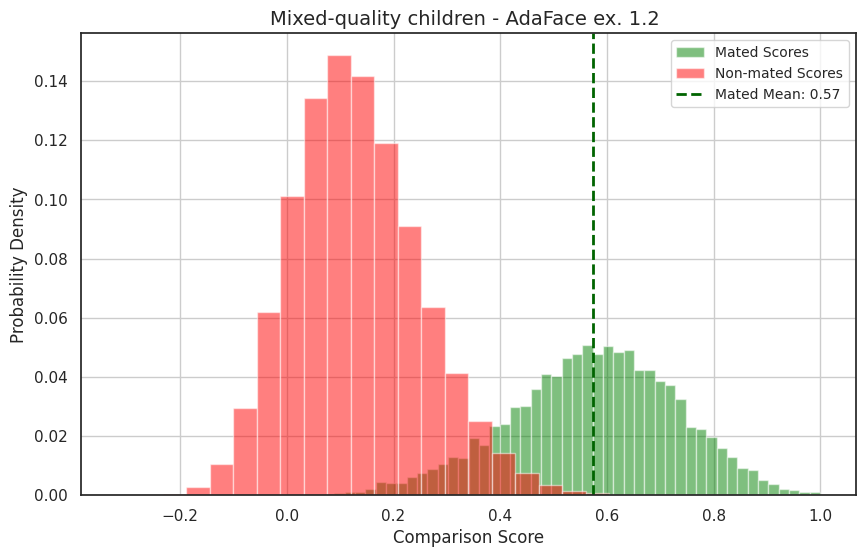

In [20]:

plot_histogram(mated_scores1, nonmated_scores1, normalise=True, title = 'Mixed-quality children - AdaFace ex. 1.2 ')


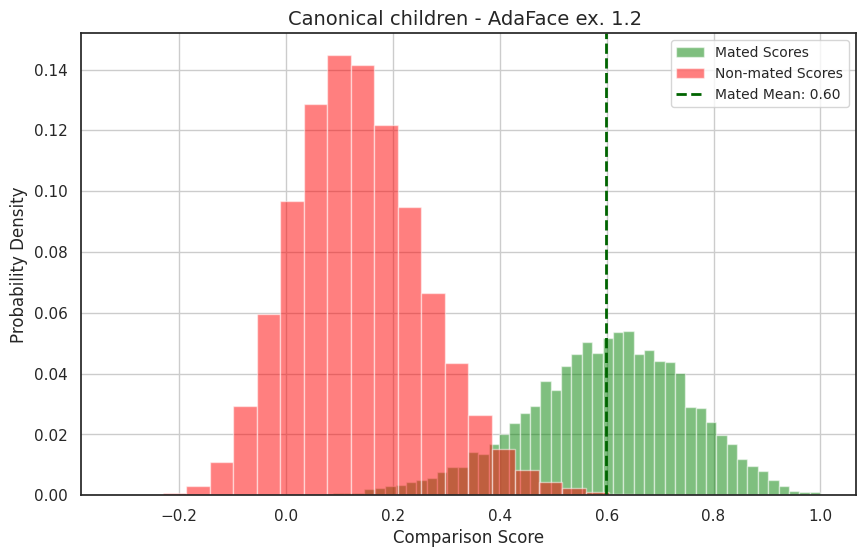

In [21]:
plot_histogram(mated_scores2, nonmated_scores2, normalise=True,title = 'Canonical children - AdaFace ex. 1.2 ')


# DET CURVES

In [6]:
mated_kde, mated_pos, mated_min, mated_max = get_kde(mated_scores1)
nonmated_kde, nonmated_pos, nonmated_min, nonmated_max = get_kde(nonmated_scores1)

In [23]:
d_prime_system1 = d_prime(mated_scores1, nonmated_scores1)
print("d' mixed =", round(d_prime_system1, round_digits))

d_prime_system2 = d_prime(mated_scores2, nonmated_scores2)
print("d' canonical =", round(d_prime_system2, round_digits))


d' mixed = 3.16811
d' canonical = 3.34325


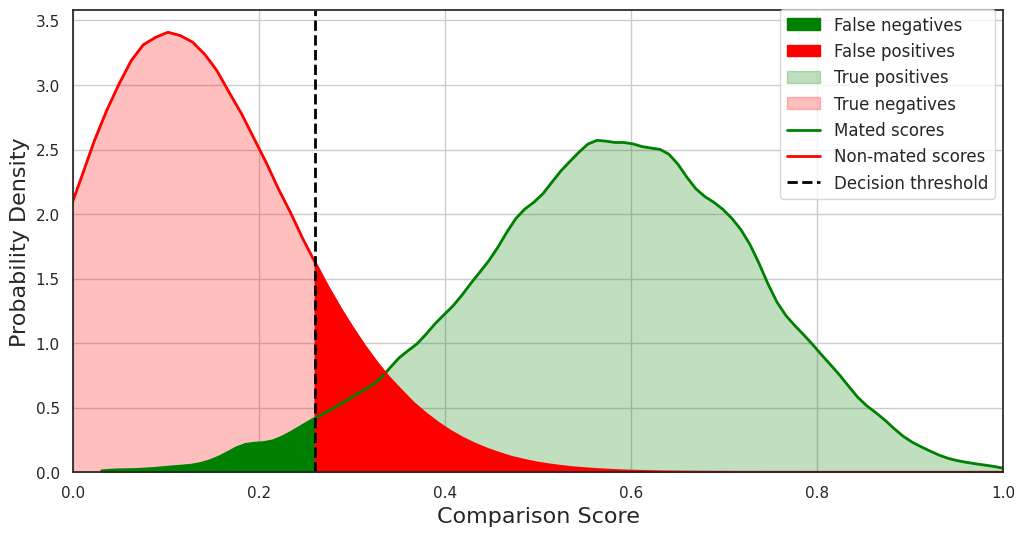

In [7]:
threshold1 = 0.26
kde_with_threshold(mated_scores1, nonmated_scores1, scores_type1, threshold1)

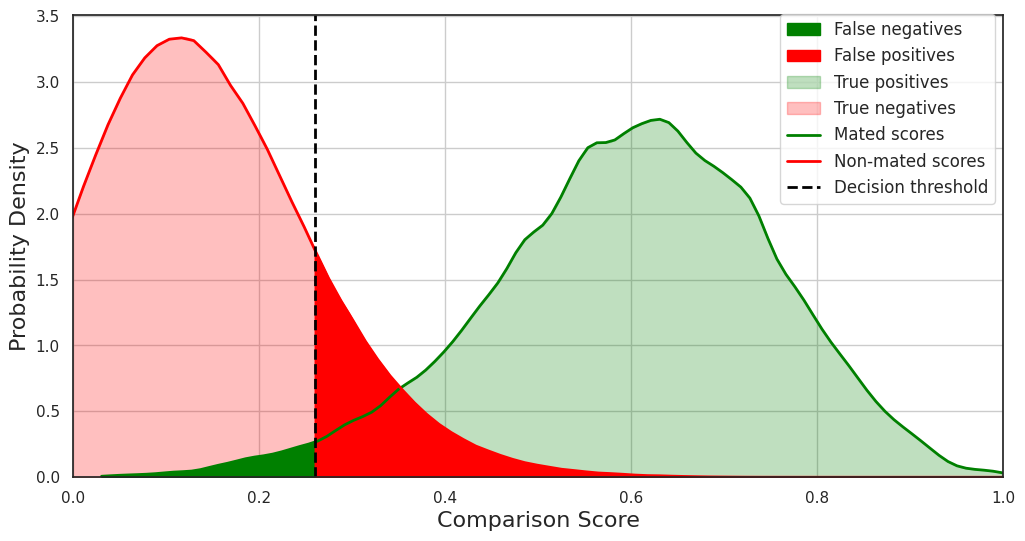

In [8]:
threshold2 = 0.26
kde_with_threshold(mated_scores2, nonmated_scores2, scores_type2, threshold2)

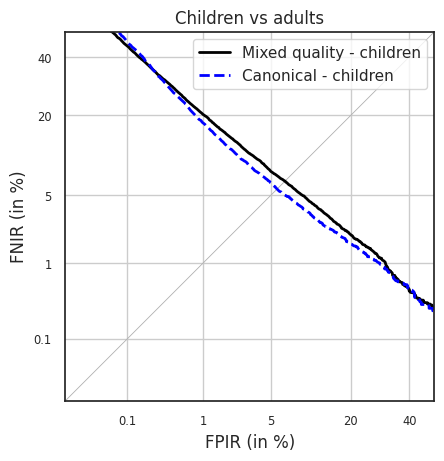

In [9]:
system_name1 = 'Mixed quality - children'
system_name2 = 'Canonical - children'

det = DET(biometric_evaluation_type='identification', abbreviate_axes=True, plot_eer_line=True, plot_title="Children vs adults")
det.x_limits = np.array([1e-4, .5])
det.y_limits = np.array([1e-4, .5])
det.x_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.x_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.y_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.y_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.create_figure()
det.plot(tar=adjust_scores_for_DET(mated_scores1, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label=system_name1)
det.plot(tar=adjust_scores_for_DET(mated_scores2, scores_type2), non=adjust_scores_for_DET(nonmated_scores2, scores_type2), label=system_name2)
det.legend_on(loc="upper right")
det.show()